## Importing Libraries


Downloading the required files from the github repository.


In [91]:
!git clone https://github.com/Akhil174405/SDG-Classifier.git

fatal: destination path 'SDG-Classifier' already exists and is not an empty directory.


In [92]:
# standard library
from typing import List

# data wrangling
import numpy as np
import pandas as pd

# visualisation
import plotly.express as px
import plotly.io as pio

# nlp
import spacy

# data modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# utils
from tqdm import tqdm

# local packages

from helpers import plot_confusion_matrix, get_top_features, fix_sdg_name

print('Loaded!')

Loaded!


In [ ]:
# other settings
pio.templates.default = 'plotly_white'

spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])


## Data Preparation

Exploring the data.

In [93]:
df_osdg = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
print('Shape:', df_osdg.shape)
display(df_osdg.head())

Shape: (32121, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


In [94]:
# calculating cumulative probability over agreement scores
df_lambda = df_osdg['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)

print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (36, 2)


,agreement,p_sum
0,0.000000,0.033716
1,0.062432,0.033747
2,0.067982,0.033779
3,0.090909,0.033872
4,0.111111,0.050185


In [95]:
# keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', df_osdg.shape)
df_osdg = df_osdg.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df_osdg.shape)
display(df_osdg.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


In [96]:
count = df_osdg['sdg'].value_counts()
print (count.sort_index())

1     1146
2      827
3     1854
4     2324
5     2286
6     1343
7     1589
8      859
9      688
10     437
11    1260
12     244
13    1129
14     705
15     542
Name: sdg, dtype: int64


In [97]:
share = df_osdg['sdg'].value_counts(1) * 100
print (share.sort_index())

1      6.650032
2      4.798932
3     10.758429
4     13.485754
5     13.265247
6      7.793187
7      9.220681
8      4.984623
9      3.992340
10     2.535832
11     7.311553
12     1.415888
13     6.551384
14     4.090988
15     3.145129
Name: sdg, dtype: float64


- This is the Preprocess_Spacy function which modifies sentences and cleanse the 
unnecessary words in the input file.
- This text will be consisting of only NOUNS, VERBS, and ADJECTIVES.




In [98]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
   
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
        
    return docs

In [ ]:
#df_osdg['docs'] = preprocess_spacy(df_osdg['text'].values)
#print('Shape:', df_osdg.shape)
#display(df_osdg.head())

- Here I used the preprcessed Pickle file in order to reduce the computations of the training model.

In [99]:
import pandas as pd
df = pd. read_pickle("SDG-Classifier/preprocess_output.pkl")
print(df.shape)

(17233, 8)


Training and Testing data will be Splitted in this chunk.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    df['docs'].values, 
    df['sdg'].values, 
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (12063,)
Shape test: (5170,)


In [ ]:
type(X_train)

I used RandomForestClassifier for the Classfication.

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
gbc = RandomForestClassifier(n_estimators=15)
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf',gbc)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf', RandomForestClassifier(n_estimators=15))])

###Confusion Matrix

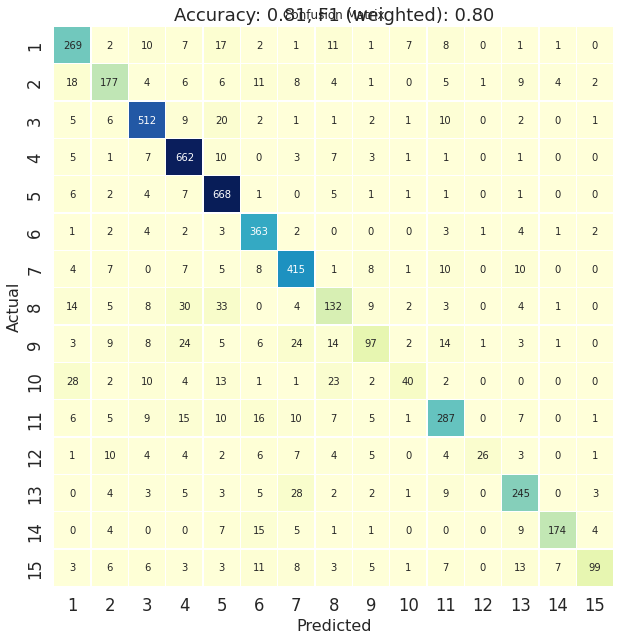

In [125]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [106]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_hat)
print('Accuracy:', score*100)

Accuracy: 80.58027079303675


Classification report

In [107]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.74      0.80      0.77       337
           2       0.73      0.69      0.71       256
           3       0.87      0.90      0.88       572
           4       0.84      0.94      0.89       701
           5       0.83      0.96      0.89       697
           6       0.81      0.94      0.87       388
           7       0.80      0.87      0.84       476
           8       0.61      0.54      0.57       245
           9       0.68      0.46      0.55       211
          10       0.69      0.32      0.43       126
          11       0.79      0.76      0.77       379
          12       0.90      0.34      0.49        77
          13       0.79      0.79      0.79       310
          14       0.92      0.79      0.85       220
          15       0.88      0.57      0.69       175

    accuracy                           0.81      5170
   macro avg       0.79      0.71      0.73      5170
weighted avg       0.80   

Getting all the probabilities for the Prediction

In [108]:
temp = pipe.predict_proba([X_test[2]])

In [109]:
temp[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.6       , 0.06666667, 0.        , 0.        , 0.        ,
       0.26666667, 0.06666667, 0.        , 0.        , 0.        ])

Intsalling PDFMINER library for converting pdf to text

In [ ]:
!pip install pdfminer

In [110]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

This is the function used for converting pdf to text

In [111]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

Uplaoding PDF to GoogleColab

In [66]:
from google.colab import files
uploaded = files.upload()

Saving Sai1.pdf to Sai1.pdf


In [112]:
var = (*uploaded,)
path2= var[0]
path2

'Sai1.pdf'

In [113]:
path1 = "/content/"
path = path1+path2
path

'/content/Sai1.pdf'

In [114]:
text = convert_pdf_to_txt(path)

Predicted a new text from the given pdf

In [115]:
dummy  = pd.DataFrame()
dummy['text'] = [text]
dummy  

,text
0,UNITED STATES\n\nSECURITIES AND EXCHANGE COMMI...


Preprocessing the Text using Spacy Library

In [116]:
dummy['docs'] = preprocess_spacy(dummy['text'].values)
dummy

1it [00:05,  5.90s/it]


,text,docs
0,UNITED STATES\n\nSECURITIES AND EXCHANGE COMMI...,state security COMMISSION report section fisca...


In [117]:
prediction = pipe.predict(dummy['docs'])
print(prediction)

[10]


Predicting one of the Sustainable Development Goals(SDG)

In [118]:
y_proba = pipe.predict_proba(dummy['docs']).flatten()
y_proba

array([0.2       , 0.06666667, 0.        , 0.        , 0.06666667,
       0.06666667, 0.        , 0.06666667, 0.        , 0.4       ,
       0.        , 0.        , 0.06666667, 0.06666667, 0.        ])

Getting the Probability  scores of the other SDG's.

In [119]:
data1= {'Goal.No':list(range(1,16)),
        'Goals':['No Poverty', 'Zero Hunger', 'Good Health and Well-Being',
         'Quality Education', 'Gender Equality', 'Clean Water And Sanitation', 'Affordable Clean Energy',
         'Decent Work And Economic Growth', 'Industry,Innovation And Infrastructure', 'Reduced Inqualities',
         'Sustainable Cities And Communities', 'Responsible Consumption And Production', 'Climate Action', 'Life Below Earth', 'Life on Land']}
df1  = pd.DataFrame(data1)
Prob= pipe.predict_proba(dummy['docs']).flatten()
df1['Probability']= Prob

sorted_df = df1.sort_values(["Probability"], ascending=False)
print(sorted_df)

    Goal.No                                   Goals  Probability
9        10                     Reduced Inqualities     0.400000
0         1                              No Poverty     0.200000
1         2                             Zero Hunger     0.066667
4         5                         Gender Equality     0.066667
5         6              Clean Water And Sanitation     0.066667
7         8         Decent Work And Economic Growth     0.066667
12       13                          Climate Action     0.066667
13       14                        Life Below Earth     0.066667
2         3              Good Health and Well-Being     0.000000
3         4                       Quality Education     0.000000
6         7                 Affordable Clean Energy     0.000000
8         9  Industry,Innovation And Infrastructure     0.000000
10       11      Sustainable Cities And Communities     0.000000
11       12  Responsible Consumption And Production     0.000000
14       15              

###Visualization using WordCloud

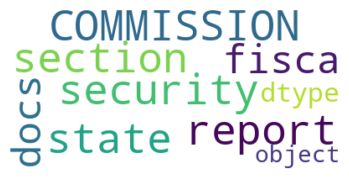

In [90]:
# example of word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
en = spacy.load('en_core_web_sm')
stop_words = en.Defaults.stop_words
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=180,
                          max_font_size=50, 
                          random_state=500,
                      ).generate(str(dummy['docs']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [80]:
image1 = files.upload()
var2 = (*image1,)
imgpath= var2[0]


Saving img2.jpg to img2 (4).jpg


In [81]:
imgpath

'img2.jpg'

In [82]:
path1 = "/content/"
img = path1+imgpath
img

'/content/img2.jpg'

In [83]:
mask = np.array(Image.open(img))

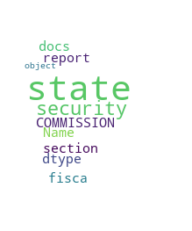

In [89]:
wc = WordCloud(stopwords=STOPWORDS,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(str(dummy['docs']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()